# Toxic Comment Classification

Group Project for MSDS621 Machine Learning at University of San Francisco. 

Kaggle competition link: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

### Team members include:
- Xinran (Grace) Zhang
- Shivee Singh
- Neha Tevathia
- Tianqi Wang
- Meng-Ting(Joyce) Chang

## Table of Content
- Overview
- Data Preprocessing and EDA
- Modeling and Evaluation
- Hyperparameters Tuning
- Ensembling
- Results Iterpretation

## Overview
The project aims to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate, we will use a dataset of comments from Wikipedia’s talk page edits, collected by Kaggle. Improvements to the current model will hopefully help online discussion become more productive and respectful.

## Data Preprocessing and Exploratory Data Analysis

### Packages Loading

In [1]:
reset -f

In [1]:
import pandas as pd
import numpy as np
import re, string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud

from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhangxinran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 📥 Loading data

In [3]:
train  = pd.read_csv("data/train.csv")
test  = pd.read_csv("data/test.csv")
test_y  = pd.read_csv("data/test_labels.csv")

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


Notice that the training data contains 159,571 observations with 8 columns and the test data contains 153,164 observations with 2 columns.

In [8]:
train.shape

(159571, 8)

In [9]:
test.shape

(153164, 2)

Below is a plot showing the comment length frequency. As noticed, most of the comments are short with only a few comments longer than 1000 words.

Text(0.5,1,'Comment length frequency')

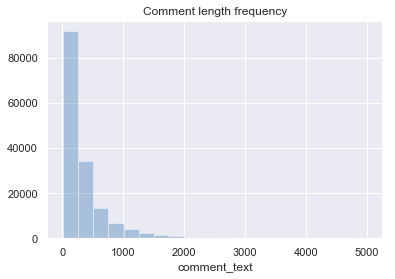

In [15]:
sns.set(color_codes=True)
comment_len = train.comment_text.str.len() 
sns.distplot(comment_len, kde=False, bins=20, color="steelblue"). \
set_title('Comment length frequency')

Below is the plot for the labeled data frequency. There is significant class imbalance since majority of the comments are considered non-toxic.

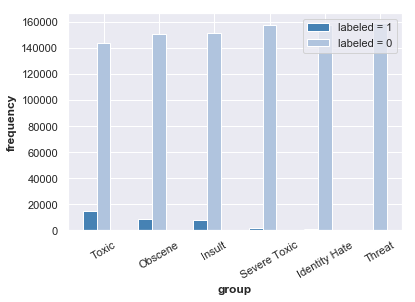

In [20]:
barWidth = 0.25

bars1 = [sum(train['toxic']==1), sum(train['obscene']==1), sum(train['insult']==1), sum(train['severe_toxic']==1),
              sum(train['identity_hate']==1), sum(train['threat']==1)]
bars2 = [sum(train['toxic']==0), sum(train['obscene']==0), sum(train['insult']==0), sum(train['severe_toxic']==0),
              sum(train['identity_hate']==0), sum(train['threat']==0)]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.ylabel('frequency', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 
                                                      'Threat'], rotation=30)
plt.legend()
plt.show()

Further exploratory shows that label `toxic` has the most observations in the training dataset while `threat` has the least.

In [142]:
# Subsetting labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

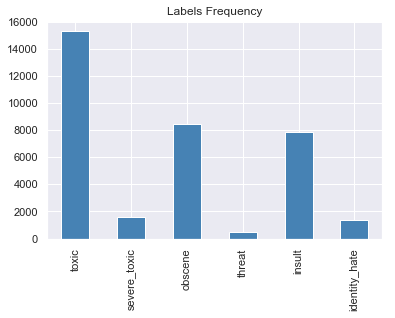

In [144]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

To get a better understanding of what the comments look like, below are examples of one clean (non-toxic) comment and one toxic (specifically, with label "toxic") comment.

In [10]:
# clean comment
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [11]:
# toxic comment
train[train.toxic==1].iloc[1,1]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

It might be a great practice to see which labels are likely to appear together with a comment.

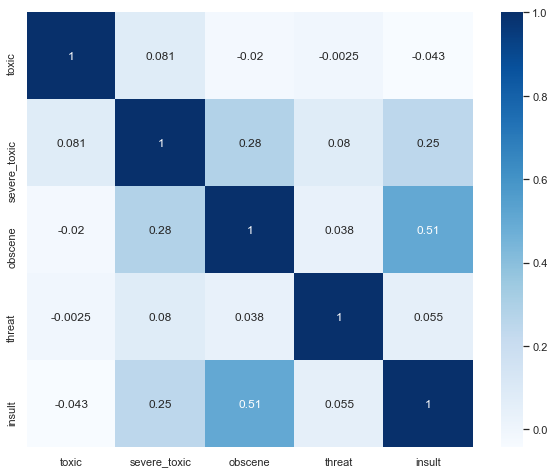

In [22]:
rowsums = train.iloc[:,2:].sum(axis=1)
temp = train.iloc[:,2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

In order to get an idea of what are the words that contribute the most to different labels, we write a function which takes in a token (i.e., labels) to generate word cloud.

In [14]:
def W_Cloud(token):
    """
    Visualize the word frequency with WordCloud.
    Bigger font size means higher frequency.
    """
    threat_context = train[train[token] == 1]   
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')             
    wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

Choose a class  to visualize the most common words contributing to the class:toxic


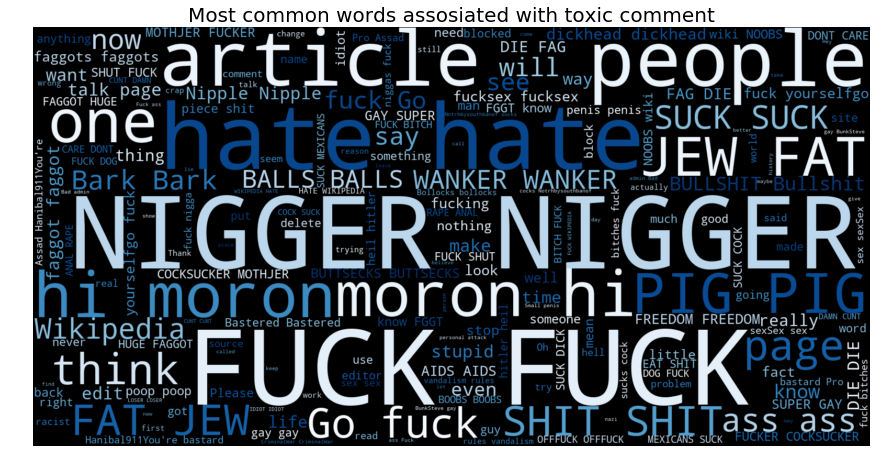

In [15]:
token = input('Choose a class  to visualize the most common words contributing to the class:')
W_Cloud(token.lower())

### Data Preprocessing and Feature Engineering

Before fitting models, we need to break down the sentence into unique words by tokenizing the comments. In the `tokenize()` function, we remove punctuations and special characters. We also lemmatize the comments and filter out comments with length below 3. Besides lemmatization, we also tried stemming but did not get a better result.

In [16]:
test_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [17]:
def tokenize(text):
    """
    Tokenize text and return a non-unique list of tokenized words
    found in the text. Normalize to lowercase, strip punctuation,
    remove stop words, drop words of length < 3.
    """
    text=text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words=nopunct.split(' ')
    
    #remove any non ascii 
    words=[word.encode('ascii','ignore').decode('ascii') for word in words]
    lmtzr=WordNetLemmatizer()
    words=[lmtzr.lemmatize(w) for w in words]
    words=[w for w in words if len(w)>2]
    return words

We determined to use TFIDF to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [18]:
vector = TfidfVectorizer(ngram_range=(1,1), analyzer= 'word' , tokenizer = tokenize , stop_words='english',
            strip_accents='unicode', use_idf=1, min_df=10)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

After the transformation, we can take a look at some of the features below.

In [30]:
vector.get_feature_names()[0:30]

['aaa',
 'aap',
 'aardvark',
 'aaron',
 'aba',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abbas',
 'abbey',
 'abbott',
 'abbreviated',
 'abbreviation',
 'abc',
 'abcnews',
 'abd',
 'abducted',
 'abduction',
 'abdul',
 'abdullah',
 'abe',
 'abel',
 'aberration',
 'abhishek',
 'abhor',
 'abhorrent',
 'abide',
 'abiding',
 'ability']

## Modeling and Evaluation

### Baseline Model

We choose Naive Bayes as our baseline model, specifically Multinomial Naive Bayes.

Also, we want to compare between different models, especially models that perform well in text classification. Thus we choose to compare Multinomial Naive Bayes with Logistic Regression, Linear Support Vector Machine and Random Forest Classifier.

### Cross Validation

In [19]:
clf1 = MultinomialNB()
clf2 = LogisticRegression()
clf3 = LinearSVC()
clf4 = RandomForestClassifier()

In [ ]:
def cross_validation_score(classifier, X_train, y_train):
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]
    
    for label in test_labels:  
        auc=cross_val_score(classifier, X_train, y_train[label], cv=10, scoring='roc_auc')
        recall=cross_val_score(classifier, X_train, y_train[label], cv=10, scoring='recall')
        precision=cross_val_score(classifier, X_train, y_train[label], cv=10, scoring='precision')
        f1=cross_val_score(classifier, X_train, y_train[label], cv=10, scoring='f1')
        methods.append([name,label,auc.mean(),recall.mean(),precision.mean(), f1.mean()])

    return methods

In [ ]:
methods1_cv=pd.DataFrame(cross_validation_score(clf1, X_train, train))
methods2_cv=pd.DataFrame(cross_validation_score(clf2, X_train, train))
methods3_cv=pd.DataFrame(cross_validation_score(clf3, X_train, train))

In [57]:
def score(classifier, X_train, y_train, X_test, y_test):
    """
    Evaluate hamming loss+F1+Recall for each label using the classifier on training dataset.
    """
    methods = []
    hloss = []
    name = classifier.__class__.__name__.split('.')[-1]
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']
    
    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)
        
        predict_df[label] = predicted

        recall=recall_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        f1=f1_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])

        conf_mat = confusion_matrix(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        methods.append([name,label,recall,f1,conf_mat])
    
    hamming_loss_score = hamming_loss(test_y[test_y['toxic']!=-1].iloc[:,1:7], predict_df[test_y['toxic']!=-1].iloc[:,1:7])
    hloss.append([name, hamming_loss_score])
    
    return hloss, methods

In [58]:
h1, methods1 = score(clf1, X_train, train, X_test, test_y)
h2, methods2 = score(clf2, X_train, train, X_test, test_y)
h3, methods3 = score(clf3, X_train, train, X_test, test_y)
h4, methods4 = score(clf4, X_train, train, X_test, test_y)

In [60]:
methods1 = pd.DataFrame(methods1)
methods2 = pd.DataFrame(methods2)
methods3 = pd.DataFrame(methods3)
methods4 = pd.DataFrame(methods4)

In [62]:
methods = pd.concat([methods1, methods2, methods3, methods4])
methods.columns = ['Model', 'Label', 'Recall', 'F1', 'Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,LogisticRegression,toxic,0.710181,0.677793
1,LogisticRegression,severe_toxic,0.302452,0.334842
2,LogisticRegression,obscene,0.609591,0.673854
3,LogisticRegression,threat,0.156398,0.229167
4,LogisticRegression,insult,0.517070,0.607265
5,LogisticRegression,identity_hate,0.265449,0.382204
6,MultinomialNB,toxic,0.532841,0.610192
7,MultinomialNB,severe_toxic,0.062670,0.114428
8,MultinomialNB,obscene,0.455432,0.586736
9,MultinomialNB,threat,0.000000,0.000000


### ⚔ Model Comparison

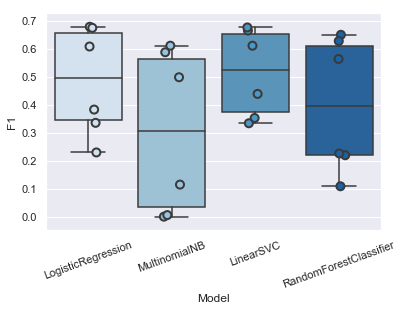

In [67]:
ax = sns.boxplot(x='Model', y='F1', data=methods, palette="Blues")
sns.stripplot(x='Model', y='F1', data=methods, 
              size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Blues")
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)

plt.show()

### LogisticRegression and LinearSVC are performing better.

In [68]:
hl1_df = pd.DataFrame(h1)
hl2_df = pd.DataFrame(h2)
hl3_df = pd.DataFrame(h3)

In [69]:
hammingloss = pd.concat([hl1_df, hl2_df, hl3_df])
hammingloss.columns = ['Model', 'Hamming_Loss']
hl = hammingloss.reset_index()
hl[['Model', 'Hamming_Loss']]

,Model,Hamming_Loss
0,LogisticRegression,0.025675
1,MultinomialNB,0.026939
2,LinearSVC,0.028476


LinearSVC performing better than anyone initially.

Plot for Logistic regression


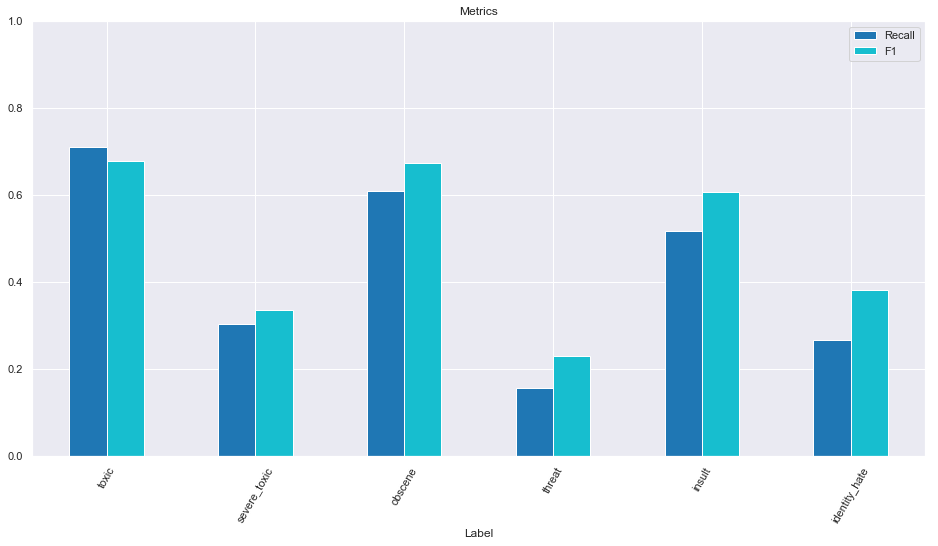

In [97]:
print("Plot for Logistic regression")
m2 = methods[methods.Model=='LogisticRegression']

m2.set_index(["Label"],inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8),kind='bar',title='Metrics', rot=60, ylim=(0.0,1),
             colormap='tab10')

### Model comparison

In [71]:
def drawConfusionMatrix(cm):
    """
    Plot Confusion matrix of input cm.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm,
           annot=True,
           annot_kws={"size": 16},
           cmap="Blues",
           fmt='.2f',
           linewidths=2, 
           linecolor='steelblue',
           xticklabels=("Non-toxic","Toxic"),
           yticklabels=("Non-toxic","Toxic"))

    plt.ylabel('True',fontsize=18)
    plt.xlabel('Predicted',fontsize=18)
    plt.show()

In [72]:
def Matrix(label):
    """
    Plot Confusion matrix for each label and call function drawConfusionMatrix().
    """
    print(f"*************** {label} labelling ***************")
    labels = {"toxic":0, "severe_toxic":1, "obscene":2, "threat":3, "insult":4, "identity_hate":5}
    
    pos = labels[label]
    for i in range(pos,len(meth),6):
        print()
        print(f"****  {meth['Model'][i]}  ***")
        cm = meth['Confusion_Matrix'][i]
        drawConfusionMatrix(cm)

Choose a class for the Confusion Matrix: toxic
*************** toxic labelling ***************

****  LogisticRegression  ***


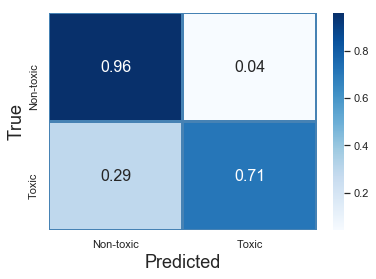


****  MultinomialNB  ***


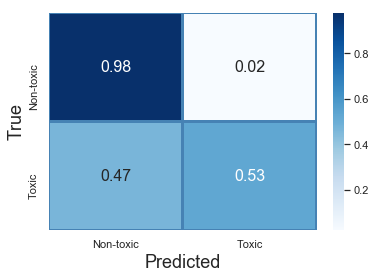


****  LinearSVC  ***


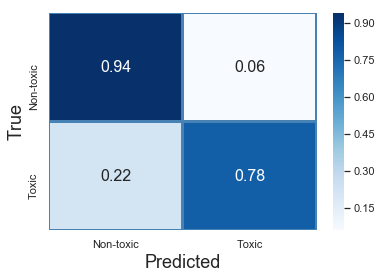


****  RandomForestClassifier  ***


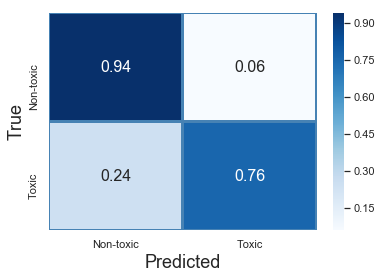

In [73]:
token = input('Choose a class for the Confusion Matrix: ')
Matrix(token.lower())

### Pipelines
Let's clean the code with pipeline and use hyperparameters to check how each model behaves.

In [74]:
# fit pipeline on best models we got from basline model set.
pipe_lr = Pipeline([
    ('lr', LogisticRegression(class_weight="balanced"))
])

pipe_linear_svm = Pipeline([
    ('svm', LinearSVC(class_weight = {1:20}))
])
  
pipelines = [pipe_lr, pipe_linear_svm]

### cross_validation_score checks how each pipeline performs on validation dataset.

In [84]:
def cross_validation_score(classifier, X_train, y_train):
    """
    Evaluates cross_val_score of f1+recall for each classifier.
    """
    methods = []
    name = classifier.steps[-1][1].__class__.__name__.split('.')[-1]
    
    for label in test_labels:  
        recall=cross_val_score(classifier, X_train, y_train[label], cv=5, scoring='recall')
        f1=cross_val_score(classifier, X_train, y_train[label], cv=5, scoring='f1')
        methods.append([name,label,recall.mean(),f1.mean()])

    return methods

In [85]:
df = pd.DataFrame(columns=['Model','Label', 'Recall', 'F1'])
df = df.fillna(0)

for pipe in pipelines:
    values = pd.DataFrame(cross_validation_score(pipe, X_train, train))
    values.columns = ['Model','Label', 'Recall', 'F1']
    df = pd.concat([df, values])

### Cross_val_score label wise

In [86]:
df

,Model,Label,Recall,F1
0,LogisticRegression,toxic,0.856152,0.723611
1,LogisticRegression,severe_toxic,0.863323,0.393186
2,LogisticRegression,obscene,0.881878,0.744921
3,LogisticRegression,threat,0.725877,0.316390
4,LogisticRegression,insult,0.872032,0.656519
5,LogisticRegression,identity_hate,0.779359,0.334230
0,LinearSVC,toxic,0.836210,0.663774
1,LinearSVC,severe_toxic,0.628213,0.413723
2,LinearSVC,obscene,0.831695,0.707722
3,LinearSVC,threat,0.447654,0.408787


### Add some comment - comparing LR and SVC

Now, we are going to compare the models using overall score instead of using label-wise to get more clarity.

In [87]:
# Find mean(f1), mean(recall), hamming loss - for each pipeline
score_df = []
for pipe in pipelines:
    f1_values = [] 
    recall_values = []
    hloss = []
    
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']
    
    for label in test_labels:
        pipe.fit(X_train, train[label])
        predicted = pipe.predict(X_test)
        
        predict_df[label] = predicted
    
        f1_values.append(f1_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
        recall_values.append(recall_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    
    hamming_loss_score = hamming_loss(test_y[test_y['toxic']!=-1].iloc[:,1:7], predict_df[test_y['toxic']!=-1].iloc[:,1:7])
    
    val = [name, mean(f1_values), mean(recall_values), hamming_loss_score]
    score_df.append(val)  

In [93]:
df_scores = pd.DataFrame(score_df,)
df_scores.columns = ['Model', 'F1', 'Recall', 'Hamming_Loss']
df_scores

,Model,F1,Recall,Hamming_Loss
0,LogisticRegression,0.947921,0.934050,0.065950
1,LinearSVC,0.951509,0.941636,0.058364


## 🤷‍ Choosing time- which one to choose




## Ensembling 

To ensemble different models, we firstly tried some models based on tree boosting, then use a voting classfier to ensemble one of the boosting model with the basic models in previous parts.

### Boosting Models

In [98]:
ab_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
boosting_models = [ab_clf, gb_clf]

In [99]:
score_df = []
for model in boosting_models:
    f1_values = [] 
    recall_values = []
    hloss = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']
    
    for idx,label in enumerate(test_labels):
        model.fit(X_train, train[label])
        predicted = model.predict(X_test)
        predict_df[label] = predicted
        f1_values.append(f1_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
        recall_values.append(recall_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
        name = model.__class__.__name__
    
    hamming_loss_score = hamming_loss(test_y[test_y['toxic']!=-1].iloc[:,1:7], predict_df[test_y['toxic']!=-1].iloc[:,1:7])
    
    val = [name, mean(f1_values), mean(recall_values), hamming_loss_score]
    score_df.append(val)  

### Scores after boosting the model

In [100]:
df_scoring = pd.DataFrame(score_df,)
df_scoring.columns = ['Model','F1','Recall', 'Hamming_Loss']
df_scoring

,Model,F1,Recall,Hamming_Loss
0,AdaBoostClassifier,0.967605,0.969771,0.030229
1,GradientBoostingClassifier,0.968933,0.971644,0.028356


#### AdaBoost and Gradient Boosting both have almost equal performance with GBoost performing slighlt better.

### Voting
Ensembling with Gradient Boosting since it performed the best.

In [101]:
ensemble_clf = VotingClassifier(estimators=[('lr', clf1), ('svm', clf3), ('gb', gb_clf)], voting='hard')
score_df = []
f1_values = [] 
recall_values = []
hl = []
predict_df = pd.DataFrame()
predict_df['id'] = test_y['id']
for label in test_labels:
    ensemble_clf.fit(X_train, train[label])
    predicted = ensemble_clf.predict(X_test)

    predict_df[label] = predicted

    f1_values.append(f1_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
    recall_values.append(recall_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
    name = 'Ensemble'

hamming_loss_score = hamming_loss(test_y[test_y['toxic']!=-1].iloc[:,1:7], predict_df[test_y['toxic']!=-1].iloc[:,1:7])
    
val = [name, mean(f1_values), mean(recall_values), hamming_loss_score]
score_df.append(val)
df_scoring = pd.DataFrame(score_df,)
df_scoring.columns = ['Model', 'F1', 'Recall', 'Hamming_Loss']
df_scoring

,Model,F1,Recall,Hamming_Loss
0,Ensemble,0.97298,0.97397,0.02603


### 🤔 What went wrong?

Analyzing the words misclassified by Logistic Classifier.

Checking for 'toxic' label first.


In [102]:
label='toxic'
lr=LogisticRegression(class_weight="balanced")
lr.fit(X_train, train[label])
Toxic_LR = lr.predict(X_test)
test_combined=pd.concat([test,test_y],axis=1)

- Misclassified 494 as non-toxic which were actually toxic

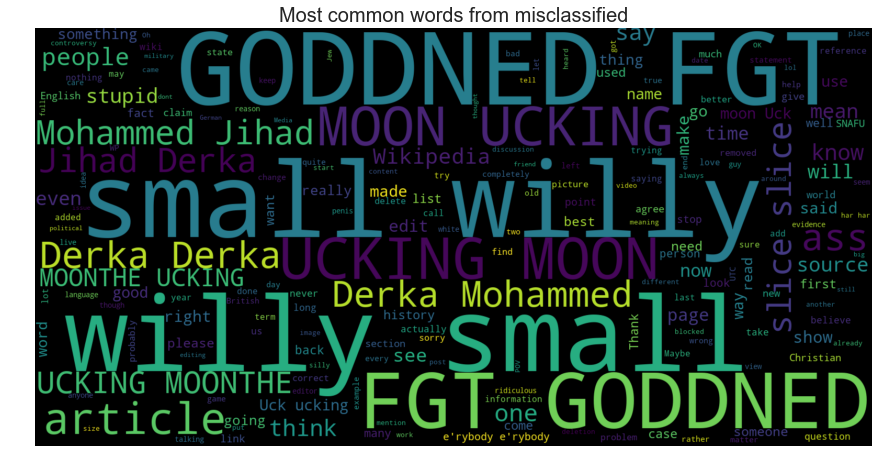

In [104]:
# Extract those comments classifier went wrong
commentCheck=test_combined[(test_combined.toxic==1) & (Toxic_LR==0)].comment_text

#Created word cloud of those comments 
neg_Check = pd.Series(commentCheck).str.cat(sep=' ')             
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_Check)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most common words from misclassified", size=20)
plt.show()

- We want to analyze why the model couldnt recognize these words. Were they not present in the training set? 
- In order to analyze we first need to pass these raw comment strings through same tokenizer and check the common tokens.

In [108]:
wrongWords=tokenize(neg_Check)
stop_words=stopwords.words('English')
wrongWords=[w for w in wrongWords if w not in stop_words]
cntr=Counter(wrongWords)
cntr.most_common(20)

[('ucking', 253),
 ('small', 238),
 ('willy', 236),
 ('goddned', 226),
 ('fgt', 226),
 ('moon', 197),
 ('derka', 140),
 ('article', 103),
 ('jihad', 72),
 ('mohammed', 71),
 ('slice', 66),
 ('moonthe', 56),
 ('like', 55),
 ('one', 53),
 ('people', 52),
 ('would', 49),
 ('think', 47),
 ('say', 46),
 ('source', 43),
 ('know', 41)]

ucking is a common word in the test set and it seems our classifier hasnt learnt to classify it as toxic. Lets check how frequent was this word in the training data.

In [110]:
neg_text_train=train['comment_text'].str.cat(sep=' ')
cntr_train=Counter(tokenize(neg_text_train))
cntr_train.get('ucking')

5

It is interesting to note that this token wasnt common in our training set. That explains why our model couldnt learn it. 
It also gives us some food for thought on how we can improve our model further.

Lets see the features and whether this word had a high feature importance

## 👓 Visual check how logistic learns

In [122]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None: plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve( estimator, 
                                    X, y, train_sizes=train_sizes, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/nehatevathia/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

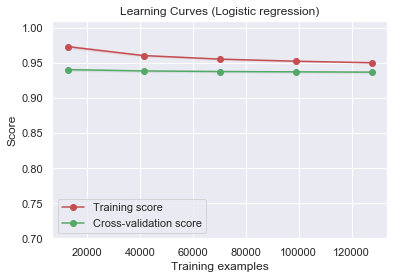

In [136]:
title = "Learning Curves (Logistic regression) for TOXIC"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LogisticRegression(class_weight="balanced")
plot_learning_curve(estimator, title, X_train, train['toxic'], ylim=(0.7, 1.01), cv=cv, n_jobs=4)

### Visualize features causing negative words

In [119]:
def plot_coefficients(classifier, feature_names, top_features=20):
    
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    plt.figure(figsize=(20, 5))
    colors = ["blue" if c < 0 else "red" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()

                          Top and Bottom 20 features              


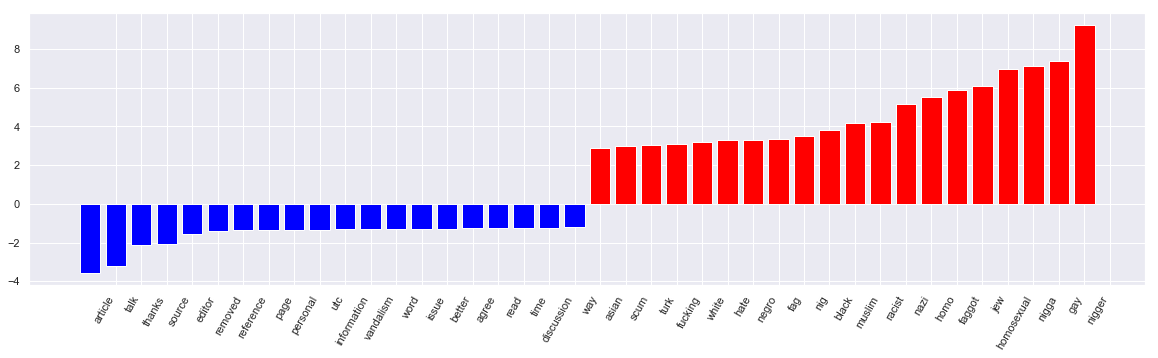

In [120]:
%matplotlib inline
print("                          Top and Bottom 20 features              ")
plot_coefficients(clf1, vector.get_feature_names())